In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reset -f

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image

import caffe
caffe.set_mode_gpu()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import python.helpers as helpers

In [49]:
trainingLogFile = "logs/train_Sunset.log"
deployModelPrototxt = "models/Sunset_deploy.prototxt"
solverPrototxt = "models/Sunset_solver.prototxt"

In [44]:
#Play-around with initial network
net = caffe.Net(deployModelPrototxt, "snapshots/Sunset_init.caffemodel", caffe.TEST)

[[ 0.5  0.5]]


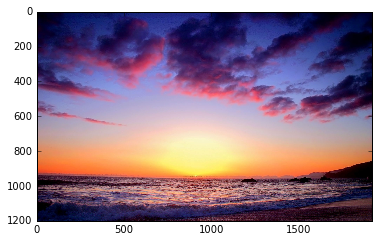

In [45]:
#Play-around with initial network
net.blobs['data'].reshape(1,3,227,227)
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
#transformer.set_channel_swap('data', (2,1,0))

im = caffe.io.load_image('wild/Sunset/7041778-twilight-sunset.jpg')
plt.imshow(im)
im = transformer.preprocess('data', im)
net.blobs['data'].data[...] = im

net.forward()
probabilities = net.blobs['prob'].data
print probabilities

In [66]:
#Do the magic
os.system("bash run_training_pipeline.sh Sunset --finetune --resize_height=256 --resize_width=256")

0

In [67]:
net = caffe.Net(deployModelPrototxt, "snapshots/Sunset_iter_1000.caffemodel", caffe.TEST)

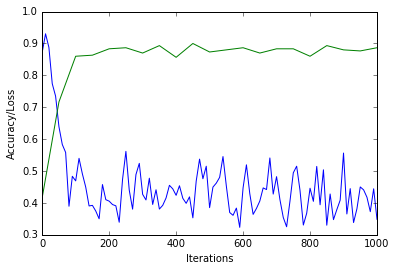

Baseline loss 0.872303
Baseline accuracy 0.416667


In [68]:
#Show training graph
iterations, losses = helpers.getLossFromTrainingFile(trainingLogFile)
plt.plot(iterations, losses)

iterations, accuracy = helpers.getAccuracyFromTrainingFile(trainingLogFile)
plt.plot(iterations, accuracy)
plt.xlabel("Iterations")
plt.ylabel("Accuracy/Loss")

plt.show()

print "Baseline loss " + losses[0]
print "Baseline accuracy " + accuracy[0]

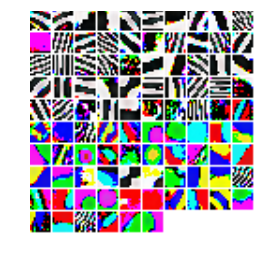

[[ 0.50908881  0.49091122]]


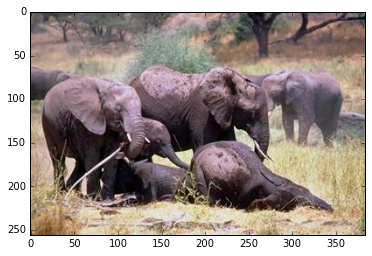

In [73]:
#Visualize learned filters from first layer
filters = net.params["conv1"][0].data
helpers.showFilterGrid(filters.transpose(0, 2, 3, 1), False)
plt.show()

#Play-around with initial network
net.blobs['data'].reshape(1,3,227,227)
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
#transformer.set_channel_swap('data', (2,1,0))

im = caffe.io.load_image('data/Sunset/test/nonsunset/543.jpg')
plt.imshow(im)
im = transformer.preprocess('data', im)
net.blobs['data'].data[...] = im

net.forward()
probabilities = net.blobs['prob'].data
print probabilities